In [1]:
# %%capture
# !pip install torch-geometric
import torch_geometric
print("torch_geometric version: ", torch_geometric.__version__)

/home/fred/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch_geometric version:  2.4.0


In [2]:
import json
from tqdm import tqdm
from typing import Tuple

import argparse
import os.path as osp

import torch
import torch.optim as optim

from torch_geometric.datasets import FB15k_237
from torch_geometric.nn import ComplEx

from sklearn.metrics import average_precision_score

import matplotlib.pyplot as plt

torch.__version__
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

device: cuda


In [ ]:
!wget https://download.microsoft.com/download/8/7/0/8700516A-AB3D-4850-B4BB-805C515AECE1/FB15K-237.2.zip
!unzip FB15K-237.2.zip

In [5]:
%load_ext autoreload
%autoreload 2

from eval import test
from plot import plot_history

In [ ]:
import importlib
importlib.reload(eval)

In [5]:
path = "./data/FB15k_torch"
train_data = FB15k_237(path, split='train')[0].to(device)

In [42]:
print(train_data)
print(train_data.edge_index.T)
# b = train_data.edge_index[1,:].item()

# print(a, b)
print()
print(train_data.edge_type.unique().size())
print()
print(train_data.num_nodes, train_data.num_edge_types, train_data.num_features)
print(train_data.edge_index[0].unique().size())
print(train_data.edge_index[1].unique().size())

Data(edge_index=[2, 272115], edge_type=[272115], num_nodes=14541)
tensor([[    0,     1],
        [    2,     3],
        [    4,     5],
        ...,
        [ 6954,  8974],
        [ 3818,  7570],
        [10244,  8396]], device='cuda:0')

torch.Size([237])

14541 237 0
torch.Size([13781])
torch.Size([13379])


In [34]:
del test
from eval import test

import argparse
import os.path as osp

import torch
import torch.optim as optim

from torch_geometric.datasets import FB15k_237
from torch_geometric.nn import ComplEx
# from sklearn.metrics import average_precision_score

EPOCHS = 1
history_freq = 5
dataset_name = 'FB15k_torch'

model_map = {
    'complex': ComplEx,
}

##########
class Args:
  model = 'complex'  # replace with your model choice

args = Args()
#########

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")
# path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'FB15k')
path = "./data/FB15k_torch"

train_data = FB15k_237(path, split='train')[0].to(device)
val_data = FB15k_237(path, split='val')[0].to(device)
test_data = FB15k_237(path, split='test')[0].to(device)

model_arg_map = {'rotate': {'margin': 9.0}}
model = model_map[args.model](
    num_nodes=train_data.num_nodes,
    num_relations=train_data.num_edge_types,
    hidden_channels=50,
    **model_arg_map.get(args.model, {}),
).to(device)

loader = model.loader(
    head_index=train_data.edge_index[0],
    rel_type=train_data.edge_type,
    tail_index=train_data.edge_index[1],
    batch_size=1000,
    shuffle=False,
)

optimizer_map = {
    'transe': optim.Adam(model.parameters(), lr=0.01),
    'complex': optim.Adagrad(model.parameters(), lr=0.001, weight_decay=1e-6),
    'distmult': optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6),
    'rotate': optim.Adam(model.parameters(), lr=1e-3),
}
optimizer = optimizer_map[args.model]

# @torch.no_grad()
# def test(data):
#     model.eval()
#     return model.test(
#         head_index=data.edge_index[0],
#         rel_type=data.edge_type,
#         tail_index=data.edge_index[1],
#         batch_size=20000,
#         k=10,
#     )


def train():
    model.train()
    total_loss = total_examples = 0
    cnt = 0
    for head_index, rel_type, tail_index in loader:
        if cnt == 1:
            print("\nTRAIN:")
            print(f"head_index: {head_index[0]}, rel_type: {rel_type[0]}, tail_index: {tail_index[0]}\n")
            print(f"head_index: {head_index}, rel_type: {rel_type}, tail_index: {tail_index}")
        optimizer.zero_grad()
        loss = model.loss(head_index, rel_type, tail_index)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
        cnt += 1
    return total_loss / total_examples

history = {'rank':[], 'mrr':[], 'hits':[], 'map_sk':[], 'map_scr':[]}

print(f"model.num_nodes: {model.num_nodes}")
print('Epochs: ', end='')
for epoch in range(1, EPOCHS + 1):
    loss = train()
    # print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    print(f'{epoch:03d} ', end='')
    if epoch % history_freq == 0:
        rank, mrr, hits, map_sk, map_scr = test(model, val_data)
        history['rank'].append(rank)
        history['mrr'].append(mrr)
        history['hits'].append(hits)
        history['map_sk'].append(map_sk)
        history['map_scr'].append(map_scr)
        # rank, hits = test(val_data)
        print(f'\nEpoch: {epoch:03d}, Val Mean Rank: {rank:.2f}, '
              # f'Val Hits@10: {hits:.4f}')
              f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}, MAP_sk: {map_sk:.4f}, MAP_scr: {map_scr:.4f}')
        print()
        print('Epochs: ', end='')

        # save history to file
        if 0:
            with open(f"./history/history_epochs_{EPOCHS}_{history_freq}_{dataset_name}.json", "w") as outfile: 
                json.dump(history, outfile)

# rank, mrr, hits_at_10 = test(test_data)
# print(f'Test Mean Rank: {rank:.2f}, Test MRR: {mrr:.4f}, '
#       f'Test Hits@10: {hits_at_10:.4f}')

plot_history({k:v for k,v in history.items() if k not in ['rank', 'map_scr', 'map_sk']}, history_freq)

device: cuda
model.num_nodes: 14541
Epochs: 
TRAIN:
head_index: 1566, rel_type: 89, tail_index: 1567

head_index: tensor([1566, 1568, 1132, 1570, 1572, 1574, 1575, 1577, 1579,  726,  397, 1580,
        1581, 1582, 1583, 1585,  938, 1127, 1589, 1591, 1314, 1593, 1594, 1595,
         106, 1598, 1599, 1601, 1602,   32, 1147, 1606,  280, 1607, 1130, 1609,
        1611, 1613,  699, 1614, 1616, 1618, 1619, 1621, 1623,  572, 1624, 1626,
          11, 1629, 1631, 1146,  434,  775,  657, 1635, 1637, 1638, 1640, 1641,
        1642, 1644, 1645, 1647, 1649, 1651, 1653, 1654, 1121, 1656, 1657, 1659,
        1661, 1662, 1664, 1666,  663,  829,  220, 1670, 1672, 1673, 1026, 1676,
        1678,  928,  500, 1681,  526, 1683, 1685, 1687, 1689, 1691,  598, 1693,
         917, 1694, 1696, 1698, 1700, 1702, 1704,  692, 1707, 1708, 1709, 1711,
        1712, 1714, 1715, 1252, 1717,  816, 1719, 1720, 1721,  344, 1723,  326,
        1725, 1727,  154,  886, 1729,  371,  138, 1733,  467, 1736, 1737, 1739,
      

TypeError: float() argument must be a string or a real number, not 'list'

<Figure size 1000x500 with 1 Axes>

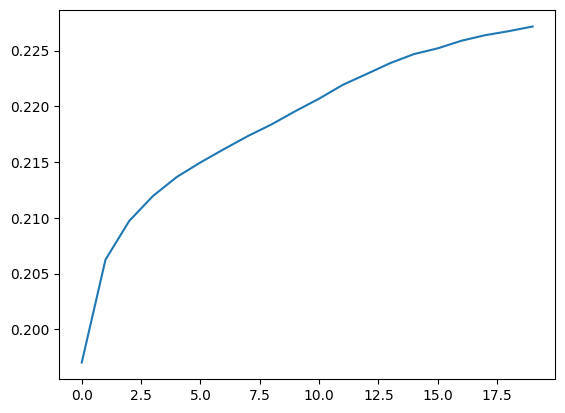

In [8]:
head_index: 1493, rel_type: 140, tail_index: 3542

plt.plot(history['mrr'])

In [ ]:
plt.plot(history['map_sk'])

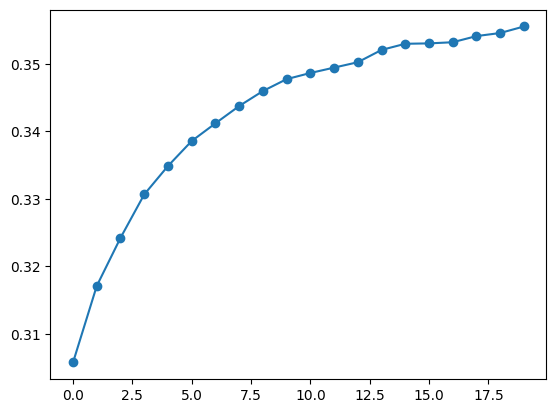

In [9]:
plt.scatter([i for i in range(0, len(history['hits']))], history['hits'])
plt.plot(history['hits'])

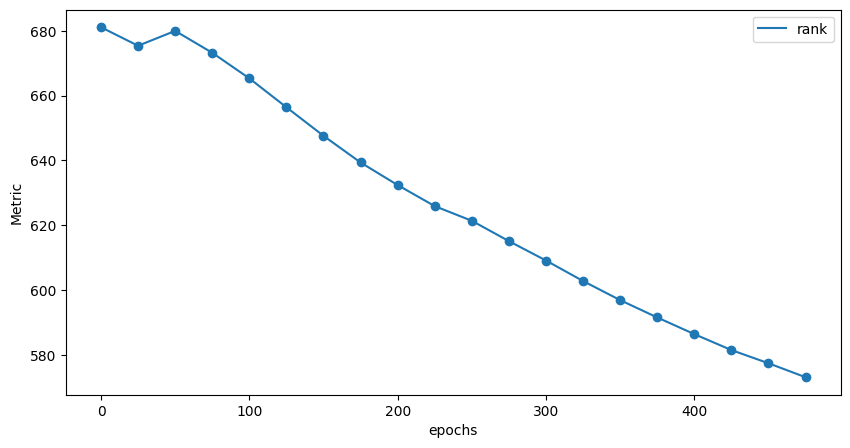

In [11]:
plot_history({k:v for k,v in history.items() if k == 'rank'})

In [20]:
# path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'FB15k')
path = "./data/FB15k_torch"

train_data = FB15k_237(path, split='train')[0].to(device)
val_data = FB15k_237(path, split='val')[0].to(device)
test_data = FB15k_237(path, split='test')[0].to(device)

Data(edge_index=[2, 272115], edge_type=[272115], num_nodes=14541)

In [25]:
FB15k_237(path, split='train')

IndexError: range object index out of range

In [13]:
from eval import test

In [19]:
del plot_history

In [2]:
from plot import plot_history

ValueError: x and y must have same first dimension, but have shapes (1,) and (20,)

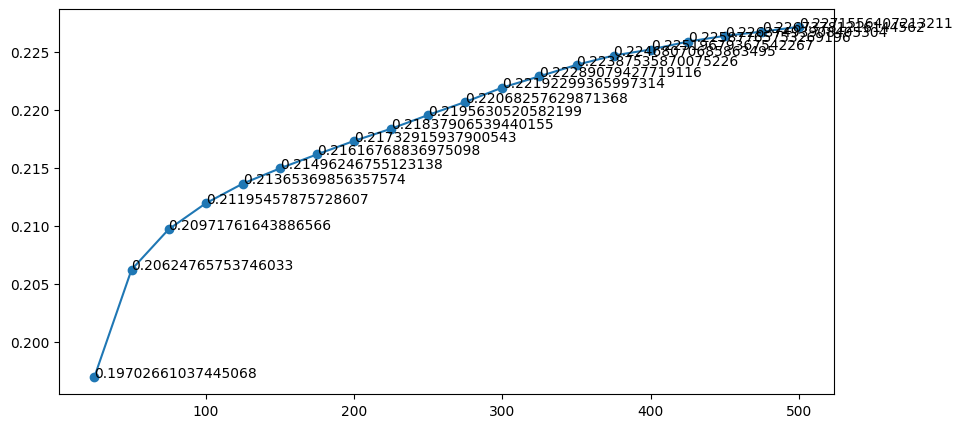

In [3]:
EPOCHS=500
history_freq=25
dataset_name='FB15k_torch'
# Opening JSON file
f = open(f"./history/history_epochs_{EPOCHS}_{history_freq}_{dataset_name}.json")
 
# returns JSON object as 
# a dictionary
data = json.load(f)

# plot_history(data, history_freq)
plot_history({k:v for k,v in data.items() if k not in ['rank', 'map_scr', 'map_sk']}, history_freq)

In [3]:

temp_dataset_name = 'FB15k_torch'
dataset_name = temp_dataset_name               # 'WN18RR_torch' | 'FB15k_torch'


# Load data from local storage
path = f"./data/{dataset_name}/"

train_data = torch.load('data/FB15k_torch/processed/train_data.pt')
valid_data = torch.load('data/FB15k_torch/processed/val_data.pt')
test_data = torch.load('data/FB15k_torch/processed/test_data.pt')

In [4]:
train_data = train_data[0]
valid_data = valid_data[0]
test_data = test_data[0]

In [5]:
print(train_data)
print(valid_data)
print(test_data)

Data(edge_index=[2, 272115], edge_type=[272115], num_nodes=14541)
Data(edge_index=[2, 17535], edge_type=[17535], num_nodes=14541)
Data(edge_index=[2, 20466], edge_type=[20466], num_nodes=14541)


In [6]:
torch.save(train_data, './data/FB15k_torch/train.pt')
torch.save(valid_data, './data/FB15k_torch/valid.pt')
torch.save(test_data, './data/FB15k_torch/test.pt')